# **Imports**

In [2]:
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, classification_report, confusion_matrix,roc_curve, roc_auc_score,precision_recall_curve


# **Load Dataset**

In [4]:
df = pd.read_csv('/content/Churn_Modelling.csv')


# **pre-processing**

In [5]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
df.dropna(inplace=True)

In [6]:
df.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [7]:
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)

In [8]:
df["Geography_Germany"] = df["Geography_Germany"].astype(float)
df["Geography_Spain"] = df["Geography_Spain"].astype(float)

In [9]:
X = df.drop("Exited", axis=1).values
y = df["Exited"].values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# **train_test_split**

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [13]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9552, 11), (3184, 11), (3184, 11), (9552,), (3184,), (3184,))

In [14]:
def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_val_tensor, y_val_tensor = to_tensor(X_val, y_val)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

In [15]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)


# **hyper-tuneing**

In [18]:
def objective(trial):
    # --- هایپرپارامترهایی که Optuna امتحان می‌کند ---
    hidden1 = trial.suggest_int("hidden1", 8, 64)
    hidden2 = trial.suggest_int("hidden2", 4, 32)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    class TunedModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(X_train.shape[1], hidden1),
                nn.ReLU(),
                nn.Dropout(dropout1),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(dropout2),
                nn.Linear(hidden2, 1)
            )

        def forward(self, x):
            return self.net(x)

    model = TunedModel()

    pos_weight = torch.tensor([sum(y_train == 0) / sum(y_train == 1)], dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # آموزش کوتاه برای هر تکرار
    for epoch in range(15):  # آموزش سریع
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    # ارزیابی روی validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor)
        val_probs = torch.sigmoid(val_logits)
        val_preds = (val_probs > 0.4).float()
        f1 = f1_score(y_val, val_preds.numpy())

    return f1


In [19]:
study = optuna.create_study(direction="maximize")  # چون f1 بالاتر بهتر است
study.optimize(objective, n_trials=50)  # مثلاً 50 بار امتحان



[I 2025-06-02 21:57:19,864] A new study created in memory with name: no-name-f007d6df-c38e-407a-b449-12f659be4689
[I 2025-06-02 21:57:30,634] Trial 0 finished with value: 0.7582725743129557 and parameters: {'hidden1': 32, 'hidden2': 4, 'dropout1': 0.25681976833733705, 'dropout2': 0.2829282723802864, 'lr': 0.0004550428448108132, 'weight_decay': 0.001985765004167773}. Best is trial 0 with value: 0.7582725743129557.
[I 2025-06-02 21:57:34,783] Trial 1 finished with value: 0.7711792851111736 and parameters: {'hidden1': 29, 'hidden2': 8, 'dropout1': 0.30259209114453706, 'dropout2': 0.4768648827716314, 'lr': 0.00337577475646893, 'weight_decay': 7.387138072954186e-05}. Best is trial 1 with value: 0.7711792851111736.
[I 2025-06-02 21:57:39,318] Trial 2 finished with value: 0.7565714285714286 and parameters: {'hidden1': 53, 'hidden2': 15, 'dropout1': 0.15259420443448168, 'dropout2': 0.22495097818978796, 'lr': 0.00010829847070898818, 'weight_decay': 0.001054304673043134}. Best is trial 1 with va

In [20]:
print("Best trial:")
print(study.best_trial)


Best trial:
FrozenTrial(number=47, state=1, values=[0.7935542718151414], datetime_start=datetime.datetime(2025, 6, 2, 22, 0, 55, 114675), datetime_complete=datetime.datetime(2025, 6, 2, 22, 0, 59, 771702), params={'hidden1': 44, 'hidden2': 29, 'dropout1': 0.10007687509203869, 'dropout2': 0.2633469623365103, 'lr': 0.0022514373652660177, 'weight_decay': 2.347647582517419e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden1': IntDistribution(high=64, log=False, low=8, step=1), 'hidden2': IntDistribution(high=32, log=False, low=4, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.01, log=True, low=1e-06, step=None)}, trial_id=47, value=None)


In [21]:
best_params = study.best_params
print("Best hyperparameters:", best_params)


Best hyperparameters: {'hidden1': 44, 'hidden2': 29, 'dropout1': 0.10007687509203869, 'dropout2': 0.2633469623365103, 'lr': 0.0022514373652660177, 'weight_decay': 2.347647582517419e-05}


# **class ChurnModel**

In [16]:
class ChurnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 44),
            nn.ReLU(),
            nn.Dropout(0.10007687509203869),
            nn.Linear(44, 29),
            nn.ReLU(),
            nn.Dropout(0.2633469623365103),
            nn.Linear(29, 1)
        )

    def forward(self, x):
        return self.net(x)


In [17]:
model = ChurnModel()
pos_weight = torch.tensor([sum(y_train == 0) / sum(y_train == 1)], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0022514373652660177, weight_decay=2.347647582517419e-05)


In [18]:
train_losses, val_losses = [], []
epochs = 1000
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 10/1000 - Train Loss: 0.4444, Val Loss: 0.4355
Epoch 20/1000 - Train Loss: 0.4309, Val Loss: 0.4269
Epoch 30/1000 - Train Loss: 0.4205, Val Loss: 0.4199
Epoch 40/1000 - Train Loss: 0.4112, Val Loss: 0.4138
Epoch 50/1000 - Train Loss: 0.4023, Val Loss: 0.4101
Epoch 60/1000 - Train Loss: 0.3967, Val Loss: 0.4035
Epoch 70/1000 - Train Loss: 0.3931, Val Loss: 0.4044
Epoch 80/1000 - Train Loss: 0.3885, Val Loss: 0.4053
Epoch 90/1000 - Train Loss: 0.3886, Val Loss: 0.3986
Epoch 100/1000 - Train Loss: 0.3874, Val Loss: 0.3970
Epoch 110/1000 - Train Loss: 0.3807, Val Loss: 0.3985
Epoch 120/1000 - Train Loss: 0.3783, Val Loss: 0.3944
Epoch 130/1000 - Train Loss: 0.3755, Val Loss: 0.3907
Epoch 140/1000 - Train Loss: 0.3729, Val Loss: 0.3883
Epoch 150/1000 - Train Loss: 0.3718, Val Loss: 0.3886
Epoch 160/1000 - Train Loss: 0.3676, Val Loss: 0.3851
Epoch 170/1000 - Train Loss: 0.3652, Val Loss: 0.3856
Epoch 180/1000 - Train Loss: 0.3649, Val Loss: 0.3894
Epoch 190/1000 - Train Loss: 0.3692, 

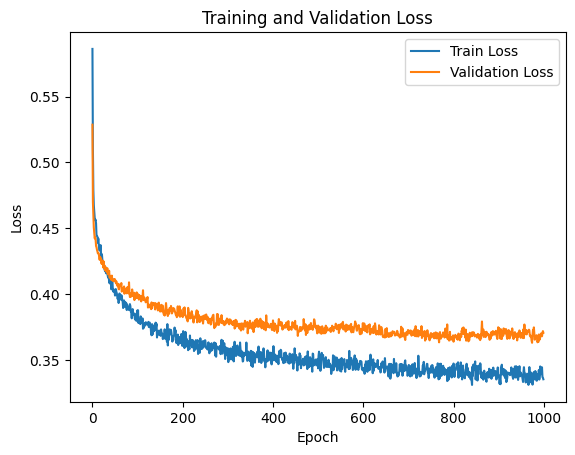

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [20]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor)
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs > 0.5).float()  # Threshold tuning
    acc = accuracy_score(y_test, test_preds.numpy())
    f1 = f1_score(y_test, test_preds.numpy())
    auc = roc_auc_score(y_test, test_probs.numpy())
    mse = mean_squared_error(y_test, test_probs.numpy())
    print(f"Test Accuracy: {acc:.4f}\nF1 Score: {f1:.4f}\nAUC: {auc:.4f}\nMSE: {mse:.4f}")

Test Accuracy: 0.8323
F1 Score: 0.8268
AUC: 0.9169
MSE: 0.1163


# **Best threshold & Report**

In [21]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor)
    test_probs = torch.sigmoid(test_logits).numpy().flatten()


precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold : {best_threshold:.2f}")


test_preds = (test_probs > best_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(y_test, test_preds))

Best threshold : 0.38

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      1623
           1       0.79      0.89      0.84      1561

    accuracy                           0.83      3184
   macro avg       0.84      0.83      0.83      3184
weighted avg       0.84      0.83      0.83      3184



# **Confusion Matrix**

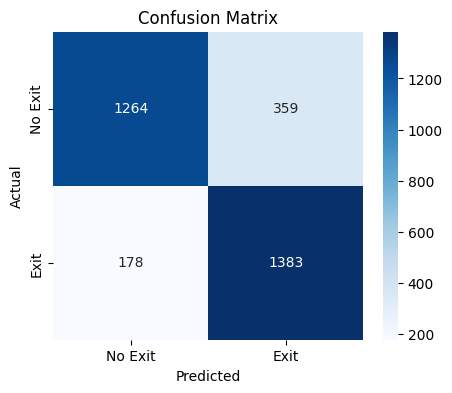

In [22]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Exit", "Exit"], yticklabels=["No Exit", "Exit"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **ROC Curve**

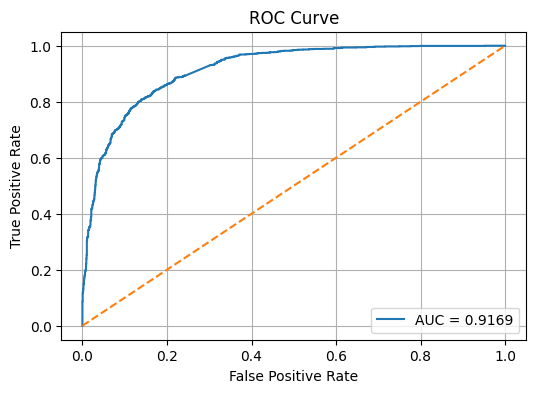

In [23]:
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, test_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


# **Precision-Recall Curve**

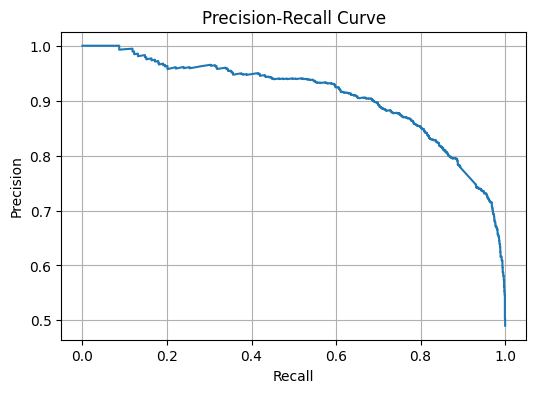

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

# **train & validation & test**

In [26]:
def evaluate_set(name, X_tensor, y_true):
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        acc = accuracy_score(y_true, preds.numpy())
        f1 = f1_score(y_true, preds.numpy())
        auc = roc_auc_score(y_true, probs.numpy())
        mse = mean_squared_error(y_true, probs.numpy())

        print(f"\n{name} Evaluation:")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"MSE: {mse:.4f}")
        print("Classification Report:\n", classification_report(y_true, preds.numpy()))


evaluate_set("Train Set", X_train_tensor, y_train)
evaluate_set("Validation Set", X_val_tensor, y_val)
evaluate_set("Test Set", X_test_tensor, y_test)



Train Set Evaluation:
Accuracy: 0.8958
F1 Score: 0.8949
AUC: 0.9630
MSE: 0.0823
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      4715
           1       0.91      0.88      0.89      4837

    accuracy                           0.90      9552
   macro avg       0.90      0.90      0.90      9552
weighted avg       0.90      0.90      0.90      9552


Validation Set Evaluation:
Accuracy: 0.8269
F1 Score: 0.8215
AUC: 0.9156
MSE: 0.1174
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1622
           1       0.83      0.81      0.82      1562

    accuracy                           0.83      3184
   macro avg       0.83      0.83      0.83      3184
weighted avg       0.83      0.83      0.83      3184


Test Set Evaluation:
Accuracy: 0.8323
F1 Score: 0.8268
AUC: 0.9169
MSE: 0.1163
Classification Report:
               precision    

# **Good Luck**